In [15]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
from time import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import numpy as np
import pandas as pd
import pickle

from lang import LanguageDataset
from preprocessing import get_vocab, word2idx, idx2word, add_sentence_tokens, trim_outliers
from nltk.tokenize import wordpunct_tokenize
from nltk.translate import bleu_score
from gensim.models import Word2Vec
from model import *
from constants import *

df = pd.read_csv("../data/preprocessed/preprocessed_train.csv")
df["en_processed"] = df["en_processed"].apply(wordpunct_tokenize)
df["hu_processed"] = df["hu_processed"].apply(wordpunct_tokenize)
df = trim_outliers(df, "en_processed", MAX_WORDS)
df = trim_outliers(df, "hu_processed", MAX_WORDS)
print(len(df.index))
df["en_processed"] = df["en_processed"].apply(add_sentence_tokens)
df["hu_processed"] = df["hu_processed"].apply(add_sentence_tokens)

input_sentences = df["en_processed"]
output_sentences = df["hu_processed"]



618


In [16]:
input_pretrained_embeddings = torch.load("../models/w2v_embeddings/embeddings_cbow_en.pt")
output_pretrained_embeddings = torch.load("../models/w2v_embeddings/embeddings_cbow_hu.pt")

with open("../models/word2index/word2index_cbow_en.pkl", 'rb') as fp:
    input_word2idx = pickle.load(fp)
with open("../models/word2index/word2index_cbow_hu.pkl", 'rb') as fp:
    output_word2idx = pickle.load(fp)
with open("../models/word2index/index2word_cbow_en.pkl", 'rb') as fp:
    input_idx2word = pickle.load(fp)
with open("../models/word2index/index2word_cbow_hu.pkl", 'rb') as fp:
    output_idx2word = pickle.load(fp)
    
# create dataloader
dataset = LanguageDataset(
    input_sentences, output_sentences, input_word2idx, output_word2idx
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [17]:
encoder = EncoderRNN(len(input_word2idx), EMBEDDING_DIM, input_pretrained_embeddings).to(device)
decoder = AttnDecoderRNN(EMBEDDING_DIM, len(output_word2idx), output_pretrained_embeddings).to(device)

translation = "en_hu"
embedding = "cbow"
attention = "attention"

# load trained model
encoder.load_state_dict(torch.load(f"../models/{translation}/{embedding}/{attention}/encoder_{MAX_WORDS}_100.model"))
encoder.eval()
decoder.load_state_dict(torch.load(f"../models/{translation}/{embedding}/{attention}/decoder_{MAX_WORDS}_100.model"))
decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(8540, 100)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=100, out_features=100, bias=True)
    (Ua): Linear(in_features=100, out_features=100, bias=True)
    (Va): Linear(in_features=100, out_features=1, bias=True)
  )
  (gru): GRU(200, 100, batch_first=True)
  (out): Linear(in_features=100, out_features=8540, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
predictions = [evaluate(encoder, decoder, test_input_sentence, input_word2idx, output_idx2word)[1:-1] for test_input_sentence in input_sentences]
targets = [sentence[1:-1] for sentence in output_sentences]

bleu_scores = []
for prediction, target in zip(predictions, targets):
    bleu_scores.append(bleu_score.sentence_bleu([target], prediction, weights = (1, 0, 0 ,0)))

bleu_scores = np.array(bleu_scores)

# bleu_scores = bleu_score.corpus_bleu(targets, predictions, weights = (1, 0, 0 ,0))

/Users/DiarmuidFogarty/.local/share/virtualenvs/NLP_Proj2-rNUYsnK4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/DiarmuidFogarty/.local/share/virtualenvs/NLP_Proj2-rNUYsnK4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/DiarmuidFogarty/.local/share/virtualenvs/NLP_Proj2-rNUYsnK4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU sc

In [19]:
best_ones = np.argsort(bleu_scores)[-3:]
worst_ones = np.argsort(bleu_scores)[:3]

In [20]:
for i in best_ones:
    print(bleu_scores[i])
    print(input_sentences[i])
    print(targets[i])
    print(predictions[i])

1.0
['<SOS>', 'membership', 'of', 'parliament', 'see', 'minutes', '<EOS>']
['a', 'parlament', 'tagjai', 'lásd', 'a', 'jegyzőkönyvet']
['a', 'parlament', 'tagjai', 'lásd', 'a', 'jegyzőkönyvet']
1.0
['<SOS>', 'thank', 'you', '.', '<EOS>']
['köszönöm', '.']
['köszönöm', '.']
1.0
['<SOS>', 'oral', 'questions', 'and', 'written', 'declarations', 'see', 'minutes', '<EOS>']
['szóbeli', 'választ', 'igénylő', 'kérdések', 'és', 'írásbeli', 'nyilatkozatok', 'lásd', 'a', 'jegyzőkönyvet']
['szóbeli', 'választ', 'igénylő', 'kérdések', 'és', 'írásbeli', 'nyilatkozatok', 'lásd', 'a', 'jegyzőkönyvet']


In [21]:
for i in worst_ones:
    print(bleu_scores[i])
    print(input_sentences[i])
    print(targets[i])
    print(predictions[i])

0.0
['<SOS>', 'we', 'must', 'drive', 'forward', 'the', 'doha', 'round', '.', '<EOS>']
['elő', 'kell', 'segítenünk', 'a', 'dohai', 'forduló', 'előrehaladását', '.']
['vissza', 'akarunk', 'térni', 'nizzához', '?']
0.0
['<SOS>', 'thank', 'you', 'for', 'permitting', 'me', 'to', 'speak', 'now', '.', '<EOS>']
['köszönöm', ',', 'hogy', 'engedélyezték', 'mostani', 'felszólalásomat', '.']
['nagyon', 'hálás', 'vagyok', 'ezért', 'erről', '!']
0.0
['<SOS>', 'palestine', 'is', 'a', 'case', 'in', 'point', '.', '<EOS>']
['palesztina', 'ügye', 'jó', 'példa', '.']
['először', 'is', 'az', 'eltérés']


In [22]:
print(bleu_scores[best_ones])
print(input_sentences[best_ones])
print(output_sentences[best_ones])
# print(predictions[best_ones])

[1. 1. 1.]
553    [<SOS>, membership, of, parliament, see, minut...
278                        [<SOS>, thank, you, ., <EOS>]
0      [<SOS>, oral, questions, and, written, declara...
Name: en_processed, dtype: object
553    [<SOS>, a, parlament, tagjai, lásd, a, jegyzők...
278                          [<SOS>, köszönöm, ., <EOS>]
0      [<SOS>, szóbeli, választ, igénylő, kérdések, é...
Name: hu_processed, dtype: object


(618,)
0.0
1.0
0.3343984506606064


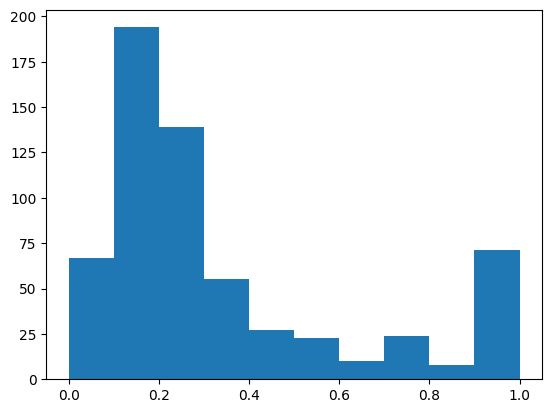

In [23]:
print(bleu_scores.shape)
print(bleu_scores.min())
print(bleu_scores.max())
print(bleu_scores.mean())
plt.hist(bleu_scores)
plt.show()

In [24]:
print(np.unique(bleu_scores, return_counts=True))

(array([0.        , 0.0716262 , 0.07357589, 0.09196986, 0.09306272,
       0.0973501 , 0.1       , 0.10108844, 0.1073539 , 0.10976233,
       0.11111111, 0.11156508, 0.11809164, 0.11942189, 0.1238397 ,
       0.125     , 0.12591707, 0.13406401, 0.14108029, 0.14285714,
       0.14715178, 0.16374615, 0.16666667, 0.17113904, 0.17973159,
       0.18612545, 0.1947002 , 0.19885318, 0.2       , 0.20217689,
       0.2147078 , 0.21952465, 0.22062423, 0.22222222, 0.23618328,
       0.23884377, 0.2476794 , 0.25      , 0.25670856, 0.27918817,
       0.28216057, 0.28571429, 0.29205029, 0.29827977, 0.3       ,
       0.30326533, 0.3220617 , 0.3274923 , 0.33093634, 0.33333333,
       0.34227808, 0.35826566, 0.3715191 , 0.37225089, 0.375     ,
       0.38940039, 0.39770636, 0.4       , 0.42857143, 0.44444444,
       0.47236655, 0.47768754, 0.49123845, 0.5       , 0.5367695 ,
       0.55837634, 0.57142857, 0.58410059, 0.6       , 0.6191985 ,
       0.625     , 0.66666667, 0.70540144, 0.75      , 0.7777